In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def parameter_selection_SVM(X_train, y_train):
    param_grid_svm = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }

    grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
    grid_search_svm.fit(X_train, y_train)
    best_svm = grid_search_svm.best_estimator_
    return best_svm, grid_search_svm.best_params_

def parameter_selection_MLP(X_train, y_train):
    param_grid_mlp = {
        'batch_size': [32, 64],
        'epochs': [10, 20],
        'activation': ['relu', 'tanh'],
        'neurons': [16, 32]
    }

    def create_mlp(optimizer='adam', activation='relu', neurons=16):
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    mlp = KerasClassifier(build_fn=create_mlp, verbose=0)
    grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5)
    grid_search_mlp.fit(X_train, y_train)
    best_mlp = grid_search_mlp.best_estimator_
    return best_mlp, grid_search_mlp.best_params_

def evaluate_model(clf, X_val, y_val, X_test, y_test, clf_name, dataset_name):
    # Compute classification error on Validation set
    val_predictions = clf.predict(X_val)
    val_error = 100 * np.sum(val_predictions != y_val) / len(y_val)
    print(f"{clf_name} Classification Error on Validation Set for {dataset_name}: {val_error:.2f}%")
    
    # Compute classification error on Test set
    test_predictions = clf.predict(X_test)
    test_error = 100 * np.sum(test_predictions != y_test) / len(y_test)
    print(f"{clf_name} Classification Error on Test Set for {dataset_name}: {test_error:.2f}%")

    # Compute confusion matrix for Test set
    conf_matrix_test = confusion_matrix(y_test, test_predictions)
    print(f"{clf_name} Confusion Matrix (Test Set) for {dataset_name}:\n{conf_matrix_test}")

    if clf_name == 'MLP':  # For MLP
        y_score = clf.predict(X_test)  # Predict using the model
        fpr, tpr, _ = roc_curve(y_test, y_score)
        mean_fpr = np.linspace(0, 1, 100)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        mean_auc = auc(mean_fpr, tpr_interp)
        plt.figure()
        plt.plot(mean_fpr, tpr_interp, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % mean_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{clf_name} ROC Curve for {dataset_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Visualization of data (for example, using PCA)
    if X_val.shape[1] > 2:
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(X_val)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_val, cmap='viridis')
        plt.title(f'{dataset_name} Dataset with PCA (Class-wise Visualization)')
        plt.show()

# Load data from the files
separable_data = np.loadtxt('A2-ring-separable.txt')
merged_data = np.loadtxt('A2-ring-merged.txt')
test_data = np.loadtxt('A2-ring-test.txt')
data_gender = pd.read_csv('A2-gender.txt', delimiter='\t', names=['longhair', 'foreheadwidthcm', 'foreheadheightcm', 'nosewide', 'noselong', 'lipsthin', 'distancenosetoliplong', 'gender'])
data = pd.read_csv('bank-additional-full.csv', delimiter=';')

datasets = [
    ("Sep", separable_data[:, :-1], separable_data[:, -1]),
    ("Merged", merged_data[:, :-1], merged_data[:, -1]),
    ("Test", test_data[:, :-1], test_data[:, -1]),
    ("Gender", data_gender.iloc[:, :-1], data_gender.iloc[:, -1]),
    ("Bank", data.drop(columns=['y']), data['y'])
]


for name, X, y in datasets:
    print(f"Evaluating dataset: {name}")
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    best_svm, best_svm_params = parameter_selection_SVM(X_train, y_train)
    print(f"Best SVM Parameters for {name}: {best_svm_params}")
    evaluate_model(best_svm, X_val, y_val, X_test, y_test, 'SVM', name)

    best_mlp, best_mlp_params = parameter_selection_MLP(X_train, y_train)
    print(f"Best MLP Parameters for {name}: {best_mlp_params}")
    evaluate_model(best_mlp, X_val, y_val, X_test, y_test, 'MLP', name)


In [ ]:
print(data_gender['gender'].isnull().sum())


In [ ]:
# Impute missing value with the mode (most frequent value)
mode_gender = data_gender['gender'].mode()[0]
data_gender['gender'].fillna(mode_gender, inplace=True)


In [ ]:
print(data_gender['gender'].isnull().sum())


Evaluating dataset: Sep
Best SVM Parameters for Sep: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVM Classification Error on Validation Set for Sep: 4.50%
SVM Classification Error on Test Set for Sep: 3.90%
SVM Confusion Matrix (Test Set) for Sep:
[[517  26]
 [ 13 444]]
Best MLP Parameters for Sep: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 32}
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
MLP Classification Error on Validation Set for Sep: 49979.20%
MLP Classification Error on Test Set for Sep: 49656.00%
MLP Confusion Matrix (Test Set) for Sep:
[[515  28]
 [ 25 432]]


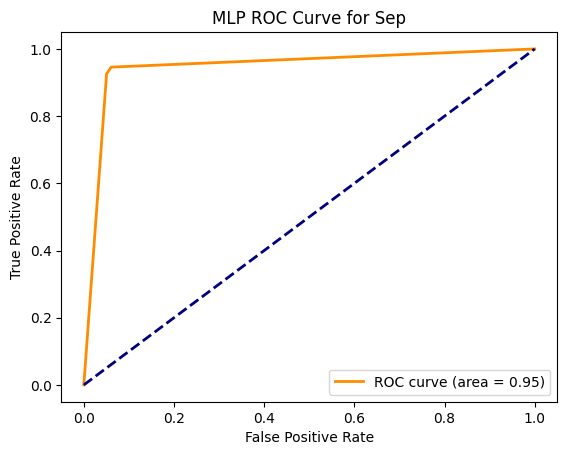

Evaluating dataset: Merged
Best SVM Parameters for Merged: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVM Classification Error on Validation Set for Merged: 25.50%
SVM Classification Error on Test Set for Merged: 23.40%
SVM Confusion Matrix (Test Set) for Merged:
[[450 123]
 [111 316]]
Best MLP Parameters for Merged: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 32}
MLP Classification Error on Validation Set for Merged: 49604.00%
MLP Classification Error on Test Set for Merged: 49051.00%
MLP Confusion Matrix (Test Set) for Merged:
[[455 118]
 [110 317]]


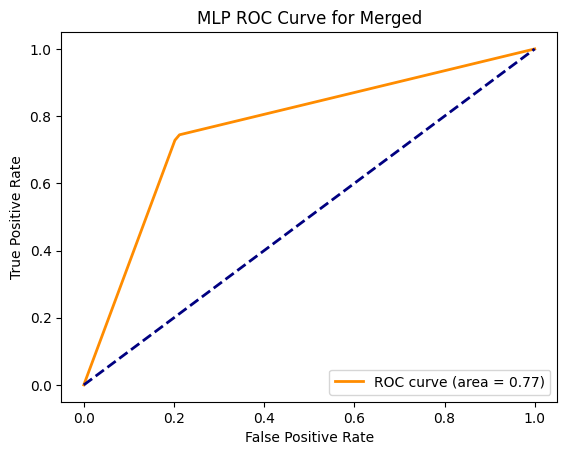

Evaluating dataset: Test
Best SVM Parameters for Test: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Classification Error on Validation Set for Test: 4.00%
SVM Classification Error on Test Set for Test: 4.70%
SVM Confusion Matrix (Test Set) for Test:
[[485  29]
 [ 18 468]]
Best MLP Parameters for Test: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 32}
MLP Classification Error on Validation Set for Test: 50014.00%
MLP Classification Error on Test Set for Test: 49958.00%
MLP Confusion Matrix (Test Set) for Test:
[[485  29]
 [ 30 456]]


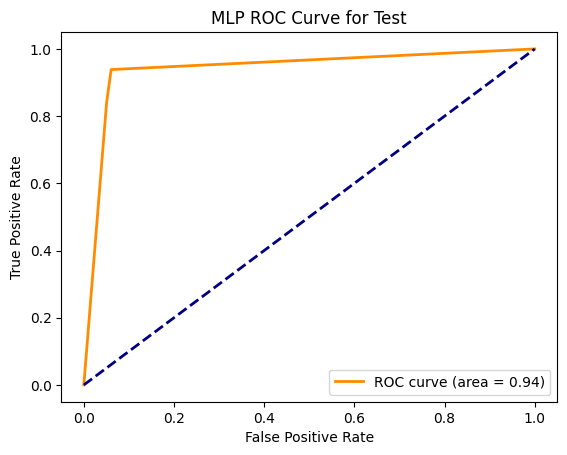

Evaluating dataset: Gender


ValueError: Input y contains NaN.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def parameter_selection_SVM(X_train, y_train):
    param_grid_svm = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }

    grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
    grid_search_svm.fit(X_train, y_train)
    best_svm = grid_search_svm.best_estimator_
    return best_svm, grid_search_svm.best_params_

def parameter_selection_MLP(X_train, y_train):
    param_grid_mlp = {
        'batch_size': [32, 64],
        'epochs': [10, 20],
        'activation': ['relu', 'tanh'],
        'neurons': [16, 32]
    }

    def create_mlp(optimizer='adam', activation='relu', neurons=16):
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    mlp = KerasClassifier(build_fn=create_mlp, verbose=0)
    grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5)
    grid_search_mlp.fit(X_train, y_train)
    best_mlp = grid_search_mlp.best_estimator_
    return best_mlp, grid_search_mlp.best_params_

def evaluate_model(clf, X_val, y_val, X_test, y_test, clf_name, dataset_name):
    # Compute classification error on Validation set
    val_predictions = clf.predict(X_val)
    val_error = 100 * np.sum(val_predictions != y_val) / len(y_val)
    print(f"{clf_name} Classification Error on Validation Set for {dataset_name}: {val_error:.2f}%")
    
    # Compute classification error on Test set
    test_predictions = clf.predict(X_test)
    test_error = 100 * np.sum(test_predictions != y_test) / len(y_test)
    print(f"{clf_name} Classification Error on Test Set for {dataset_name}: {test_error:.2f}%")

    # Compute confusion matrix for Test set
    conf_matrix_test = confusion_matrix(y_test, test_predictions)
    print(f"{clf_name} Confusion Matrix (Test Set) for {dataset_name}:\n{conf_matrix_test}")

    if clf_name == 'MLP':  # For MLP
        y_score = clf.predict(X_test)  # Predict using the model
        fpr, tpr, _ = roc_curve(y_test, y_score)
        mean_fpr = np.linspace(0, 1, 100)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        mean_auc = auc(mean_fpr, tpr_interp)
        plt.figure()
        plt.plot(mean_fpr, tpr_interp, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % mean_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{clf_name} ROC Curve for {dataset_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Visualization of data (for example, using PCA)
    if X_val.shape[1] > 2:
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(X_val)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_val, cmap='viridis')
        plt.title(f'{dataset_name} Dataset with PCA (Class-wise Visualization)')
        plt.show()

# Load data from the files
separable_data = np.loadtxt('A2-ring-separable.txt')
merged_data = np.loadtxt('A2-ring-merged.txt')
test_data = np.loadtxt('A2-ring-test.txt')
data_gender = pd.read_csv('A2-gender.txt', delimiter='\t', names=['longhair', 'foreheadwidthcm', 'foreheadheightcm', 'nosewide', 'noselong', 'lipsthin', 'distancenosetoliplong', 'gender'])
data = pd.read_csv('bank-additional-full.csv', delimiter=';')

datasets = [
    ("Sep", separable_data[:, :-1], separable_data[:, -1]),
    ("Merged", merged_data[:, :-1], merged_data[:, -1]),
    ("Test", test_data[:, :-1], test_data[:, -1]),
    ("Gender", data_gender.iloc[:, :-1], data_gender.iloc[:, -1]),
    ("Bank", data.drop(columns=['y']), data['y'])
]


for name, X, y in datasets:
    print(f"Evaluating dataset: {name}")
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    best_svm, best_svm_params = parameter_selection_SVM(X_train, y_train)
    print(f"Best SVM Parameters for {name}: {best_svm_params}")
    evaluate_model(best_svm, X_val, y_val, X_test, y_test, 'SVM', name)

    best_mlp, best_mlp_params = parameter_selection_MLP(X_train, y_train)
    print(f"Best MLP Parameters for {name}: {best_mlp_params}")
    evaluate_model(best_mlp, X_val, y_val, X_test, y_test, 'MLP', name)


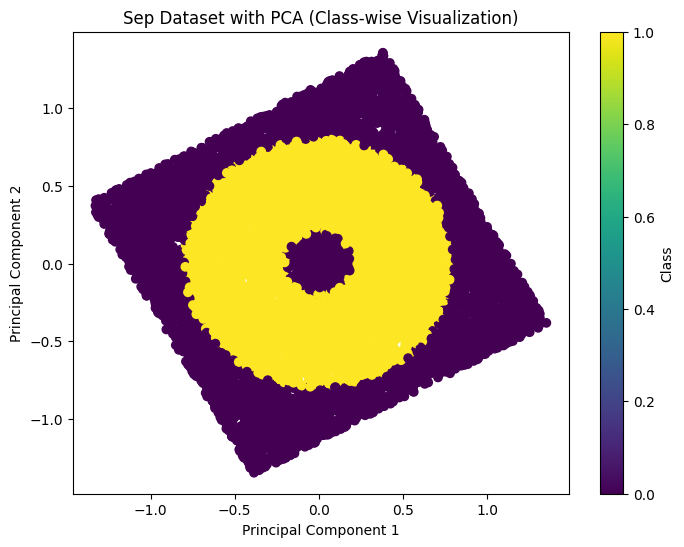

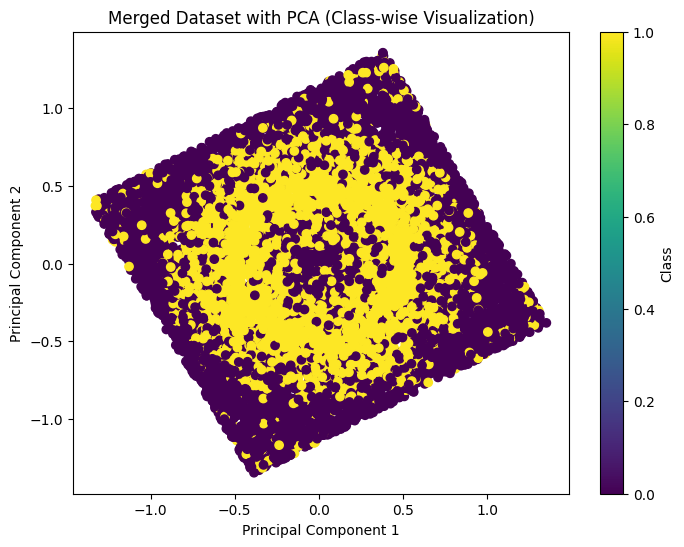

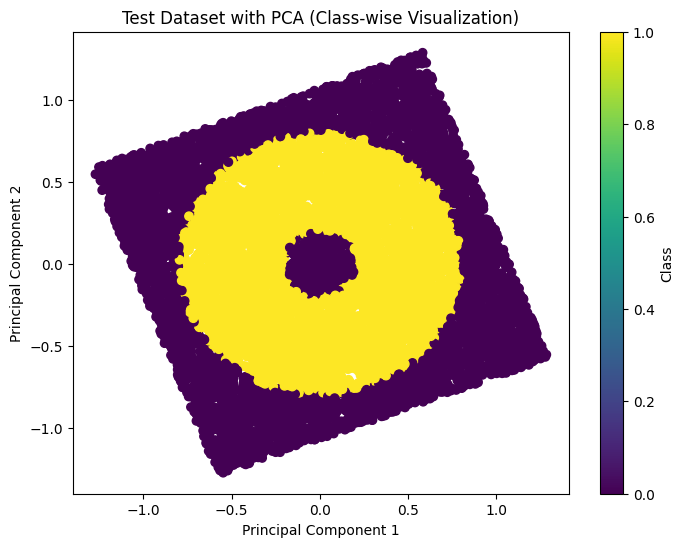

ValueError: could not convert string to float: '5001 7 1'

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define a function to plot datasets with PCA
def plot_pca_scatter(dataset_name, X_val, y_val):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(X_val)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_val, cmap='viridis')
    plt.title(f'{dataset_name} Dataset with PCA (Class-wise Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Class')
    plt.show()

# Plotting scatter plots with class-wise coloring for all datasets
for dataset_name, X_val, y_val in datasets:
    plot_pca_scatter(dataset_name, X_val, y_val)
